In [2]:
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
from matplotlib import pyplot as plt
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate#this is fast
from math import atan2, degrees
import os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time

In [ ]:
src = r'\\fatherserverdw\Q\research\images\CLUE\3D study\he\c1'
dst = os.path.join(src,'imcrop')
if not os.path.exists(dst): os.mkdir(dst)
imlist = natsorted([_ for _ in os.listdir(src) if _.lower().endswith(('ndpi','svs'))])

In [4]:
import glob,os
src = r'\\fatherserverdw\Q\research\images\skin_aging\deeplab_trainingset\tif\prediction\avgsm'
src = r'\\fatherserverdw\Q\research\images\CLUE\3D study\he\c1\1um'
imlist = glob.glob(os.path.join(src,'*.tif'))
imlist = natsorted(imlist)
imname = imlist[8]
minTA = 10000
minTAhole = 100
minDermhole = 5000
minepisize=1000
whitespace=12
src = os.path.dirname(imname)
fn, ext = os.path.splitext(os.path.basename(imname))
print(imname)

\\fatherserverdw\Q\research\images\CLUE\3D study\he\c1\1um\25C1.tif


In [8]:
# open image
im = Image.open(imname)
TAbig = np.array(im)
# rescale to expedite
(width, height) = (im.width // 10, im.height // 10)
im_resized = im.resize((width, height), resample=0)
TA = np.array(im_resized)
sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec
sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole / 100).astype(np.uint8)  # 7sec
bw = closing(TA < whitespace, square(3))  # 12 is background
bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
bw = remove_small_holes(bw, area_threshold=minTAhole)

IndexError: tuple index out of range

In [ ]:
plt.imshow(bw)

In [ ]:

# define background
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
sure_bg = cv2.dilate(opening, kernel, iterations=3)
# define middleground
unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)
# label that background is 1 and objects are 2~N and middleground is zero
sure_fg_label = label(sure_fg).astype(np.int32)
sure_fg_label = sure_fg_label + 1
sure_fg_label[unknown] = 0
# perform watershed based on the marker
TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR)
label_image = cv2.watershed(TAbgr, sure_fg_label)
# iterate each section
epi = (TA==1)|(TA==2)
derm = (2<TA) & (TA<whitespace)
derm = remove_small_holes(derm, area_threshold=minDermhole)
epi2 = epi & ~derm
epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)
numsec=1
startA = time()
msktmp = label_image == numsec+1
mskderm = msktmp & derm
mskepi = msktmp & epi2

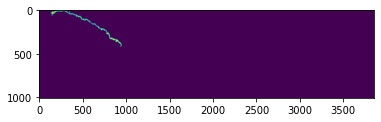

In [6]:
plt.imshow(mskepi)

In [7]:
# align horizontal
[xt2, yt2] = np.where(mskepi)
vertices = np.array([xt2[::10], yt2[::10]]).T
vc = vertices - vertices.mean(axis=0)
U, S, Vt = np.linalg.svd(vc)
k = Vt.T
d0 = -degrees(atan2(k[0, 1], k[0, 0]))
d0

63.77605151385101

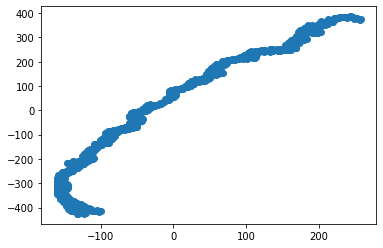

In [10]:
plt.scatter(vc[:,0],vc[:,1])

In [8]:
TAtmp = deepcopy(TAbig)
TAtmp[cv2.resize(msktmp.astype(np.int8),TAtmp.shape[::-1],interpolation = cv2.INTER_NEAREST) == 0] = 0 #scale back up to perform rotation
mskrot = rotate(TAtmp, d0 - 90, resize=True, preserve_range=True,order=0)  # this is slow why? # this cause pixel valie change

-26.22394848614899

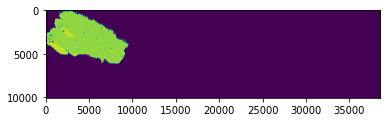

In [13]:
plt.imshow(TAtmp)

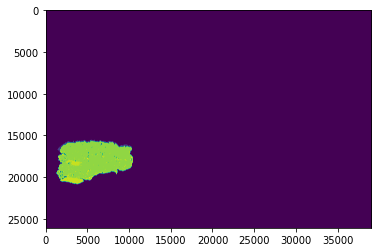

In [15]:
mskrot = rotate(TAtmp, 26.22, resize=True, preserve_range=True,order=0)
plt.imshow(mskrot)

In [11]:
[xt, yt] = np.where(mskrot)
[xt2, yt2] = np.where((mskrot == 1) | (mskrot == 2))
mskrot2 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
if np.mean(xt) - np.mean(xt2) < 0:  # if dermis is above epidermis, flip it
    print('rotated')
    mskrot2 = np.rot90(np.rot90(mskrot2))
mskrot2[mskrot2 == 0] = whitespace  # assign whitespace value to background
print(round(time()-startA),'sec elapsed for one section')

1354 sec elapsed for one section


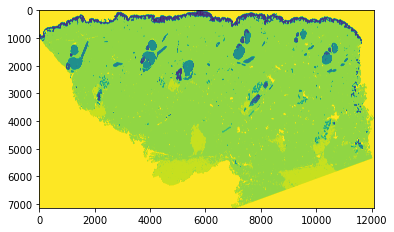

In [12]:
plt.imshow(mskrot2)

In [5]:

import glob,os
src = r'\\fatherserverdw\Q\research\images\skin_aging\deeplab_trainingset\tif\prediction\avgsm'
imlist = glob.glob(os.path.join(src,'*.png'))
imlist = natsorted(imlist)
imname = imlist[2]
minTA = 10000
minTAhole = 100
minDermhole = 5000
minepisize=1000
whitespace=12
src = os.path.dirname(imname)

fn, ext = os.path.splitext(os.path.basename(imname))

# open image
im = Image.open(imname)
TAbig = np.array(im)
Image.fromarray(TAbig.astype('int8')).save(os.path.join('test.png'))

In [9]:
Image.fromarray(TAtmp.astype('int8')).save(os.path.join('TAtmp.png'))

In [11]:
mskrot = rotate(TAtmp, d0 - 90, resize=True, preserve_range=True,order=0)  #
Image.fromarray(mskrot.astype('int8')).save(os.path.join('mskrot.png'))